In [1]:
from utils.analysis_helpers import * 
from utils.plot_helpers import *
import pandas as pd
import seaborn as sns
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

### training and test performance

In [2]:
N_collection = [20, 40, 80]
V_factors = [1, 2, 4, 8]

performance = {'N': [], '|V|': [], 'factor': [], 
               'train_acc': [], 'test_acc': [], 
               'train_mae': [], 'test_mae': [], 'random_mae': []}

for N in N_collection:
    
    min_V = 2*N + 1
    
    for factor in V_factors: 
        
        V = min_V * factor
        
        interaction_train = load_interaction(N, V, mode='validation')
        interaction_test = load_interaction(N, V, mode='test')
        
        acc_train, mae_train = calc_performance(interaction_train)
        acc_test, mae_test = calc_performance(interaction_test)
        if factor == 1:
            random_mae = calc_random_mae(interaction_train)
        
        performance['N'].append(N)
        performance['|V|'].append(V)
        performance['factor'].append(factor)
        performance['train_acc'].append(acc_train.item())
        performance['train_mae'].append(mae_train.item())
        performance['test_acc'].append(acc_test.item())
        performance['test_mae'].append(mae_test.item())
        performance['random_mae'].append(random_mae.item())
        
performance = pd.DataFrame(performance)

In [3]:
performance

,N,|V|,factor,train_acc,test_acc,train_mae,test_mae,random_mae
0,20,41,1,0.821159,0.159091,0.249370,1.568182,11.833502
1,20,82,2,0.964736,0.113636,0.282116,2.090909,11.833502
2,20,164,4,0.994962,0.068182,0.005038,1.750000,11.833502
3,20,328,8,0.992443,0.113636,0.012594,1.181818,11.833502
4,40,81,1,0.758757,0.089286,1.822868,3.458333,23.563320
5,40,162,2,0.937211,0.190476,0.249835,2.851191,23.563320
6,40,324,4,0.990086,0.154762,0.031725,2.857143,23.563320
7,40,648,8,0.990747,0.178571,0.019167,2.083333,23.563320
8,80,161,1,0.473836,0.301829,10.743776,10.039634,46.850502
9,80,322,2,0.533277,0.228659,6.347502,7.841464,46.850502


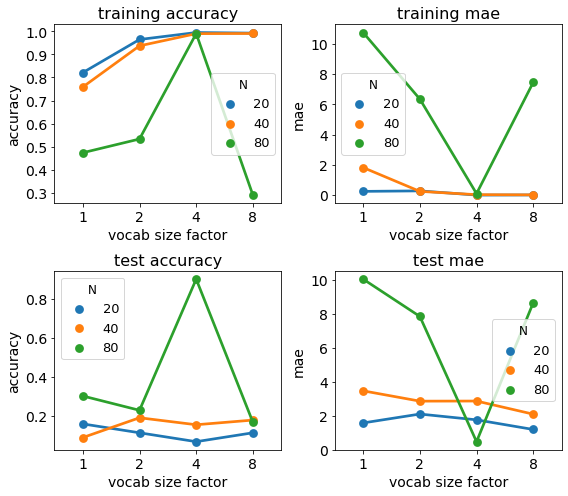

In [32]:
plt.figure(figsize=(8,7))
for i in range(4):
    y = ['train_acc', 'train_mae', 'test_acc', 'test_mae'][i]
    plt.subplot(2, 2, i+1)
    sns.pointplot(x='factor', hue='N', y=y, data=performance)
    plt.ylabel(['accuracy', 'mae', 'accuracy', 'mae'][i], fontsize=14)
    plt.xlabel('vocab size factor', fontsize=14)
    plt.title(['training accuracy', 'training mae', 'test accuracy', 'test mae'][i], fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    l = plt.legend(fontsize=13, title='N')
    l.get_title().set_fontsize(fontsize='large')
plt.tight_layout()

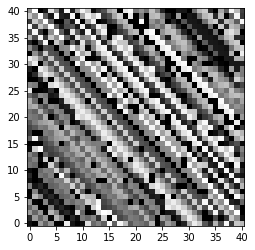

In [226]:
plot_symbol_per_input(logs)

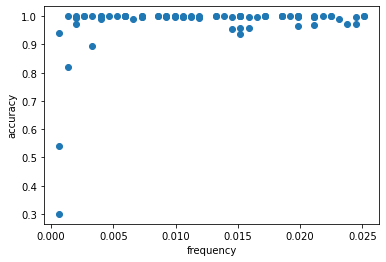

In [180]:
R = plot_accuracy_versus_frequency(logs)

In [181]:
information_scores(test_logs, N)

{'NMI_sums': 0.9009494067332878,
 'NMI_numbers': 0.7004069948772167,
 'polysemy_sums': 0.11346390508173065,
 'polysemy_numbers': 0.44923266956310115,
 'synonymy_sums': 0.08416087248382394,
 'synonymy_numbers': 0.03830794161392154}

In [182]:
calc_performance(logs)

(tensor(0.9921), tensor(0.0235), (tensor(-0.0114), tensor(0.0036)))